# Goal:
QA instrumentation for the user preferences panel.

[Instrumentation ticket](https://phabricator.wikimedia.org/T350417)   | [QA ticket](https://phabricator.wikimedia.org/T350709)


# Instrumentation note

| Event was logged                   | event.action | event.name                                                 |
|:------------------------------------|:--------------:|:------------------------------------------------------------|
| User chooses Column Width Standard | click        | vector-client-pref-vector-feature-limited-width-value-1    |
| User chooses Column Width Wide     | click        | vector-client-pref-vector-feature-limited-width-value-0    |
| User chooses Font Size Small       | click        | vector-client-pref-vector-feature-custom-font-size-value-0 |
| User chooses Font Size Standard    | click        | vector-client-pref-vector-feature-custom-font-size-value-1 |
| User chooses Font Size Large       | click        | vector-client-pref-vector-feature-custom-font-size-value-2 |
| User chooses Font Size X-Large     | click        | vector-client-pref-vector-feature-custom-font-size-value-3 |


QAed on 2023-12-14

In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [2]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
options(repr.plot.width = 15, repr.plot.height = 10)

# QA events in desktopwebuiactionstracking schema

## By event.name, user type, skin name

In [41]:
query <- "
select   event.skin,
    event.isAnon, 
event.name, 
COUNT(1) AS clicks,
COUNT(DISTINCT event.token) AS sessions,
COUNT(DISTINCT event.pageToken) AS pages
FROM event.desktopwebuiactionstracking
WHERE year=2023 and month=12
AND event.action='click' 
AND event.name LIKE 'vector-client-pref-vector-feature%'
GROUP BY event.skin, event.isAnon, event.name
"

In [42]:
df <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [43]:
df

skin        isanon name                                                      
1 vector-2022 false  vector-client-pref-vector-feature-limited-width-value-0   
2 vector-2022 false  vector-client-pref-vector-feature-limited-width-value-1   
3 vector-2022 false  vector-client-pref-vector-feature-custom-font-size-value-0
4 vector-2022 false  vector-client-pref-vector-feature-custom-font-size-value-1
5 vector-2022 false  vector-client-pref-vector-feature-custom-font-size-value-2
  clicks sessions pages
1 927    485      617  
2 809    425      552  
3 709    376      479  
4 971    438      567  
5 491    311      391

In [44]:
df %>% 
  filter(if_any(starts_with("name"), ~ substr(.x, 1, 56)=='vector-client-pref-vector-feature-custom-font-size-value'))

skin        isanon name                                                      
1 vector-2022 false  vector-client-pref-vector-feature-custom-font-size-value-0
2 vector-2022 false  vector-client-pref-vector-feature-custom-font-size-value-1
3 vector-2022 false  vector-client-pref-vector-feature-custom-font-size-value-2
  clicks sessions pages
1 709    376      479  
2 971    438      567  
3 491    311      391

In [46]:
nchar('vector-client-pref-vector-feature-limited-width-value')

[1] 53

In [47]:
df %>% 
  filter(if_any(starts_with("name"), ~ substr(.x, 1, 53)=='vector-client-pref-vector-feature-limited-width-value'))

skin        isanon name                                                   
1 vector-2022 false  vector-client-pref-vector-feature-limited-width-value-0
2 vector-2022 false  vector-client-pref-vector-feature-limited-width-value-1
  clicks sessions pages
1 927    485      617  
2 809    425      552

### Findings
No events for user choosing Font Size X-Large (font-size-value-3) yet.   
Only captured events from logged-in user.   
Only captured events in `vector-2022` skin.   

## By wikis

In [16]:
query <- "
SELECT   wiki, 
COUNT(1) AS clicks,
COUNT(DISTINCT event.token) AS sessions,
COUNT(DISTINCT event.pageToken) AS pages
FROM event.desktopwebuiactionstracking
WHERE year=2023 and month=12
AND event.action='click' 
AND event.name IN  ( 'vector-client-pref-vector-feature-limited-width-value-1',
'vector-client-pref-vector-feature-limited-width-value-0', 
'vector-client-pref-vector-feature-custom-font-size-value-0',
'vector-client-pref-vector-feature-custom-font-size-value-1',
'vector-client-pref-vector-feature-custom-font-size-value-2',
'vector-client-pref-vector-feature-custom-font-size-value-3'
)
GROUP BY wiki
"

In [17]:
df <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



### Findings

As of Dec 13, schema has captured events from 45 wikis.

## Daily trend

In [19]:
query <- "
SELECT   TO_DATE(dt) AS event_date,
event.name,
COUNT(1) AS clicks,
COUNT(DISTINCT event.token) AS sessions,
COUNT(DISTINCT event.pageToken) AS pages
FROM event.desktopwebuiactionstracking
WHERE year=2023 and month=12
AND event.action='click' 
AND event.name IN  ( 'vector-client-pref-vector-feature-limited-width-value-1',
'vector-client-pref-vector-feature-limited-width-value-0', 
'vector-client-pref-vector-feature-custom-font-size-value-0',
'vector-client-pref-vector-feature-custom-font-size-value-1',
'vector-client-pref-vector-feature-custom-font-size-value-2',
'vector-client-pref-vector-feature-custom-font-size-value-3'
)
GROUP BY  TO_DATE(dt), event.name
"

In [20]:
df <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [22]:
df$event_date <- as.Date(df$event_date)

In [32]:
nchar('vector-client-pref-vector-feature-custom-font-size-value')

[1] 56

df  %>%
   filter(if_any(starts_with("name"), ~ substr(.x, 1, 56)=='vector-client-pref-vector-feature-custom-font-size-value')) %>%
  head(5)

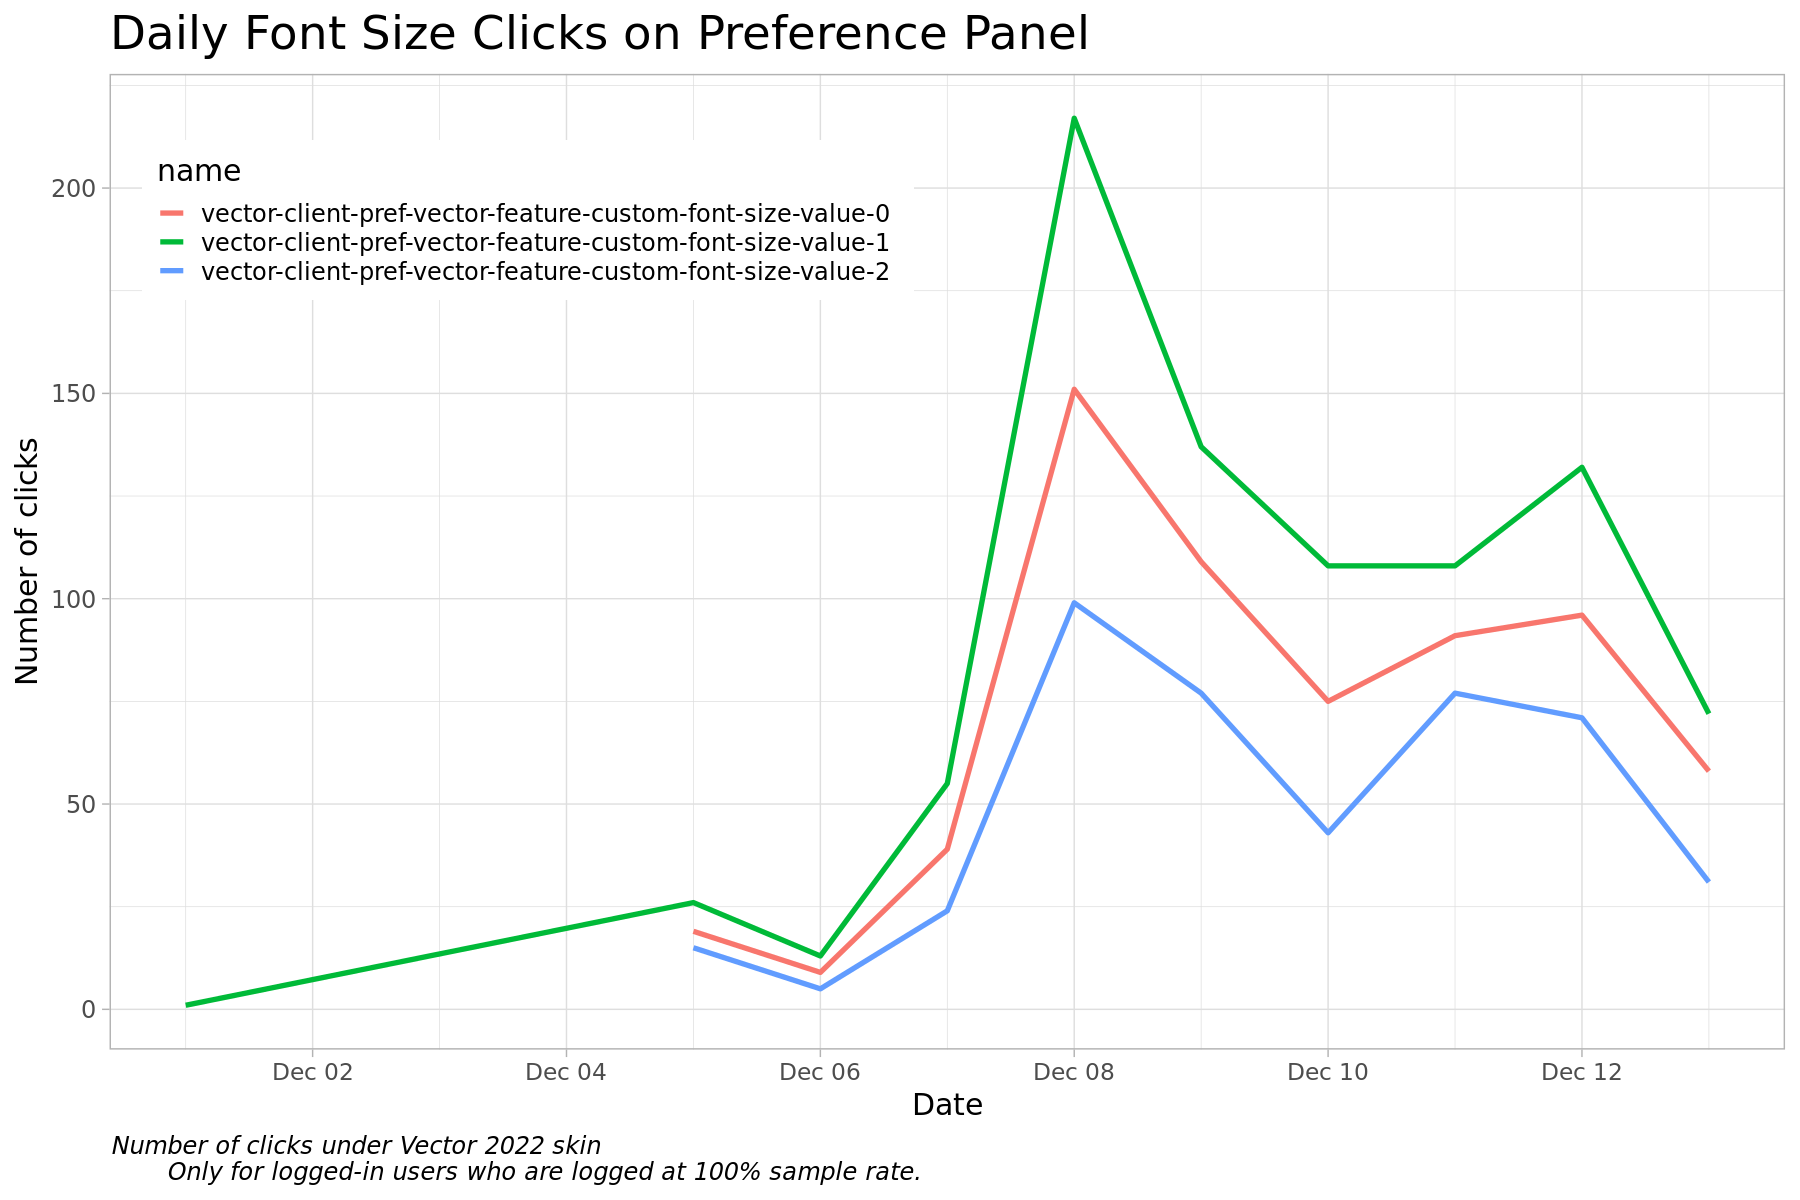

In [39]:
daily_g <- df  %>%
   filter(if_any(starts_with("name"), ~ substr(.x, 1, 56)=='vector-client-pref-vector-feature-custom-font-size-value')) %>% 
   ggplot(mapping=aes(x=event_date, y=clicks, color=name)) +
   geom_line( size = 1.5) +
  #scale_color_manual(values= c("#FF0000", "#000099"), name = "Event Name")  +
  labs(title = 'Daily Font Size Clicks on Preference Panel',
     x = 'Date',
     y = 'Number of clicks',
     caption = "Number of clicks under Vector 2022 skin
       Only for logged-in users who are logged at 100% sample rate.") +
theme_light(base_size=18) +
theme(legend.position=c(.25,.85), 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
daily_g

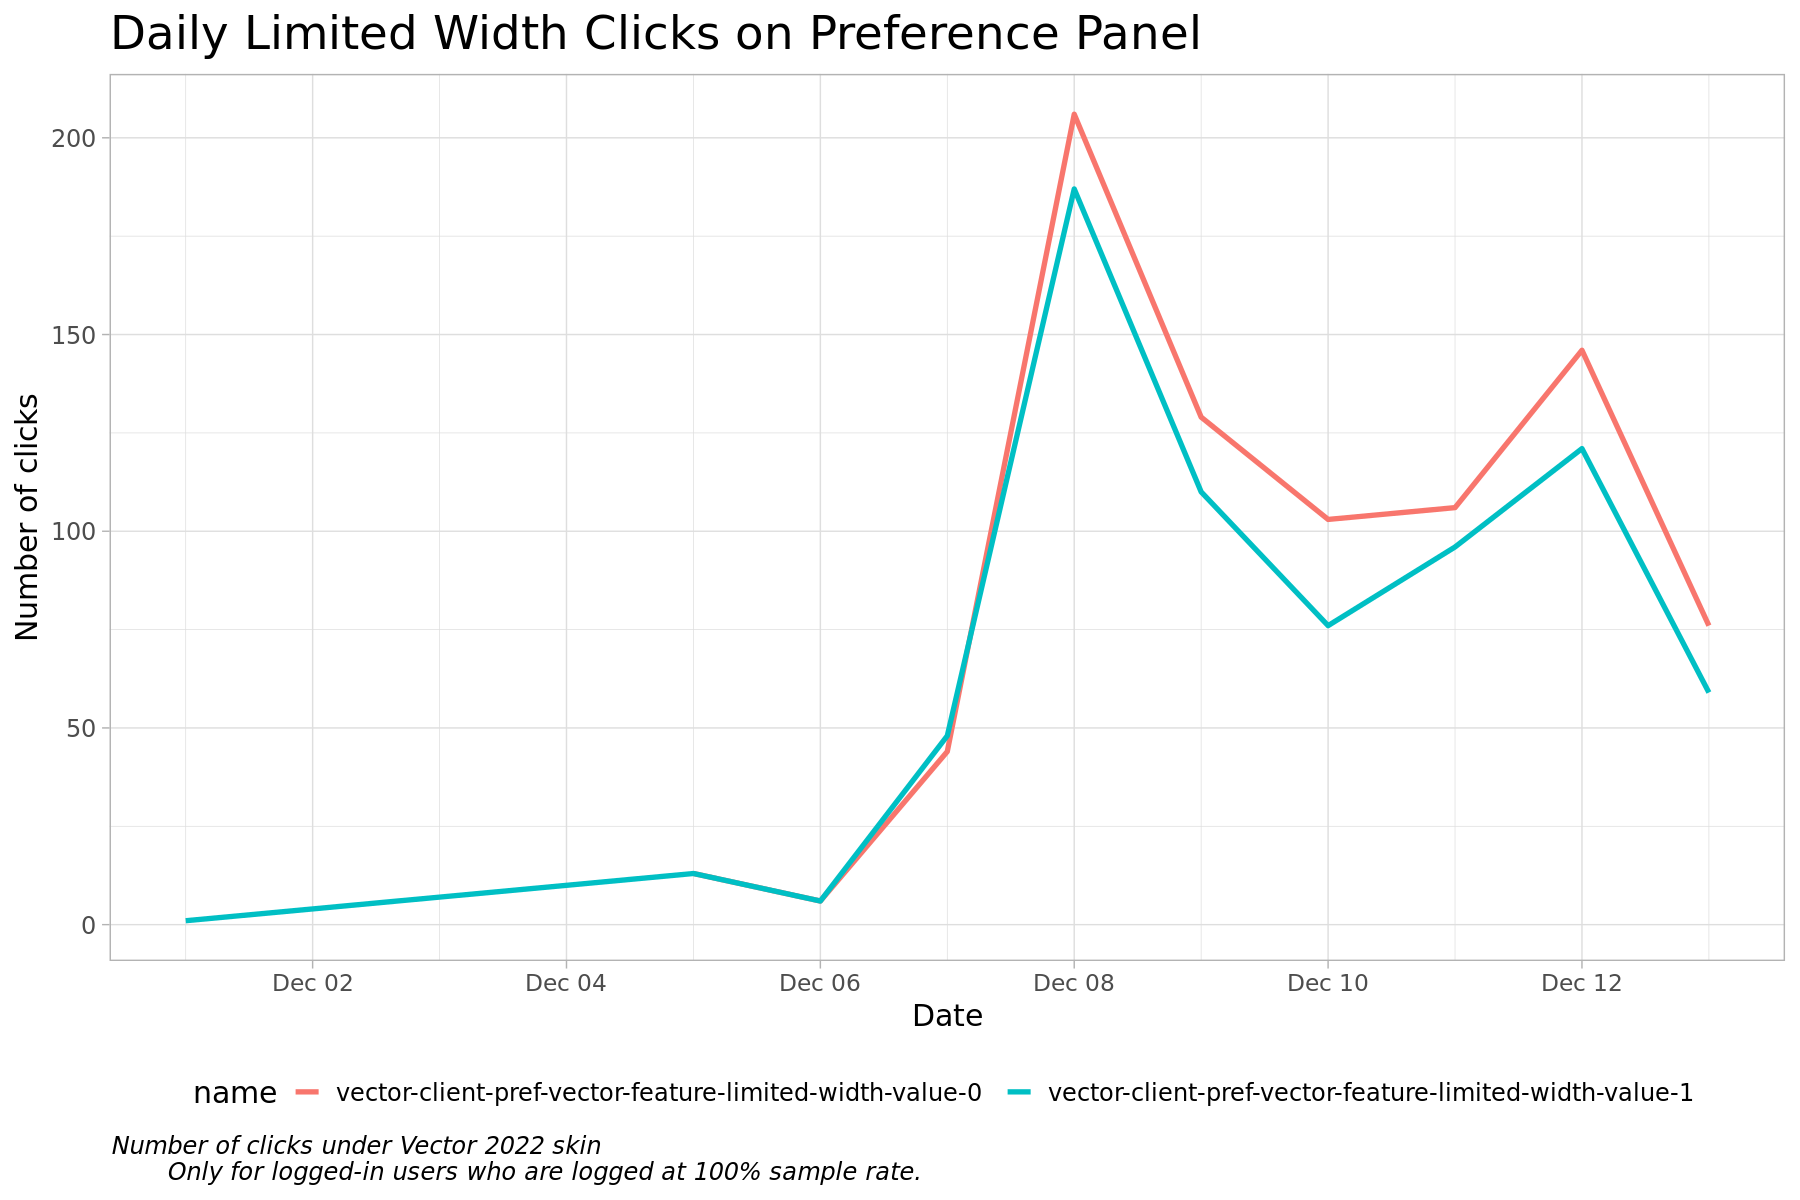

In [30]:
daily_g <- df  %>%
   filter(name=='vector-client-pref-vector-feature-limited-width-value-0' | name=='vector-client-pref-vector-feature-limited-width-value-1') %>%
   ggplot(mapping=aes(x=event_date, y=clicks, color=name)) +
   geom_line( size = 1.5) +
  #scale_color_manual(values= c("#FF0000", "#000099"), name = "Event Name")  +
  labs(title = 'Daily Limited Width Clicks on Preference Panel',
     x = 'Date',
     y = 'Number of clicks',
     caption = "Number of clicks under Vector 2022 skin
       Only for logged-in users who are logged at 100% sample rate.") +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
daily_g

### Findings

 Events started becoming available around Dec 6, 2023